## Import data

In [ ]:
# === CORE LIBRARIES ===
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === STYLING ===
sns.set(style="whitegrid", palette="muted", color_codes=True)
warnings.filterwarnings('ignore')

# === DATA PREPROCESSING ===
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from imblearn.over_sampling import SMOTE

# === MODEL SELECTION ===
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    cross_val_score
)

# === FEATURE SELECTION ===
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# === MODELS ===
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from xgboost import XGBClassifier

# === METRICS ===
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# === STATISTICAL TESTS ===
from scipy.stats import chi2_contingency, ttest_ind


In [7]:
# Load the dataset
df = pd.read_csv(r'Data\German_credit\german_credit_data.csv')

# Rename columns from German to English
df.rename(columns={
    'laufkont': 'checking_account_status',
    'laufzeit': 'duration_months',
    'moral': 'credit_history',
    'verw': 'purpose',
    'hoehe': 'credit_amount',
    'sparkont': 'savings_account_bonds',
    'beszeit': 'employment_duration_years',
    'rate': 'installment_rate_pct',
    'famges': 'personal_status_sex',
    'buerge': 'guarantor',
    'wohnzeit': 'residence_duration_years',
    'verm': 'property',
    'alter': 'age',
    'weitkred': 'other_installment_plans',
    'wohn': 'housing',
    'bishkred': 'existing_credits_at_bank',
    'beruf': 'job',
    'pers': 'num_dependents',
    'telef': 'telephone',
    'gastarb': 'foreign_worker',
    'kredit': 'credit_rating'
}, inplace=True)

# Check the result
print(df.columns, len(df.columns))
df.head()

Index(['checking_account_status', 'duration_months', 'credit_history',
       'purpose', 'credit_amount', 'savings_account_bonds',
       'employment_duration_years', 'installment_rate_pct',
       'personal_status_sex', 'guarantor', 'residence_duration_years',
       'property', 'age', 'other_installment_plans', 'housing',
       'existing_credits_at_bank', 'job', 'num_dependents', 'telephone',
       'foreign_worker', 'credit_rating'],
      dtype='object') 21


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account_bonds,employment_duration_years,installment_rate_pct,personal_status_sex,guarantor,residence_duration_years,property,age,other_installment_plans,housing,existing_credits_at_bank,job,num_dependents,telephone,foreign_worker,credit_rating
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1,1


## EDA

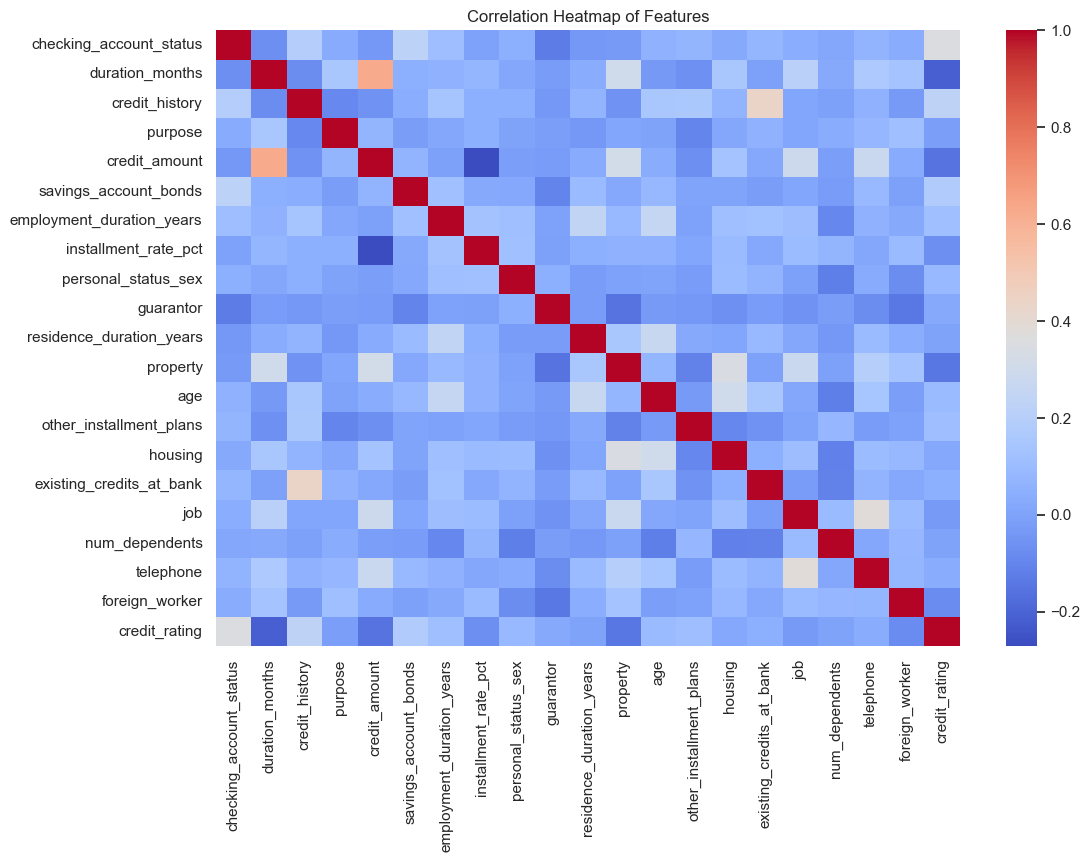

In [31]:
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()


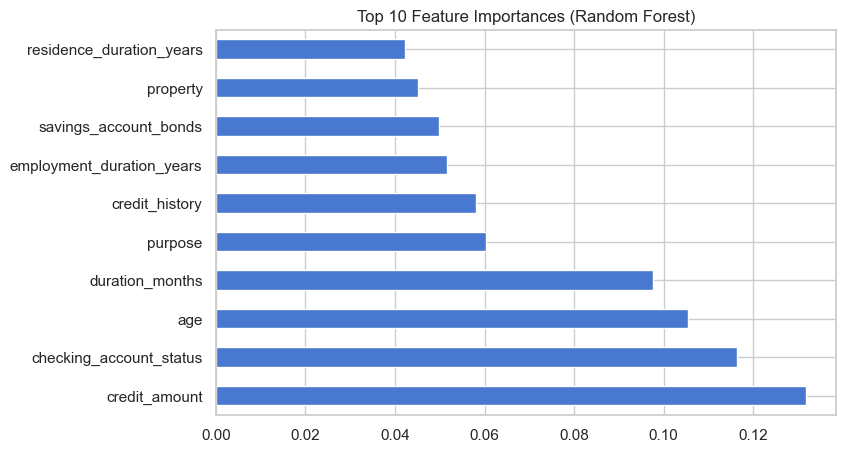

In [ ]:
X = df.drop('credit_rating', axis=1)
y = df['credit_rating']

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importance.head(10).plot(kind='barh', figsize=(8,5))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()


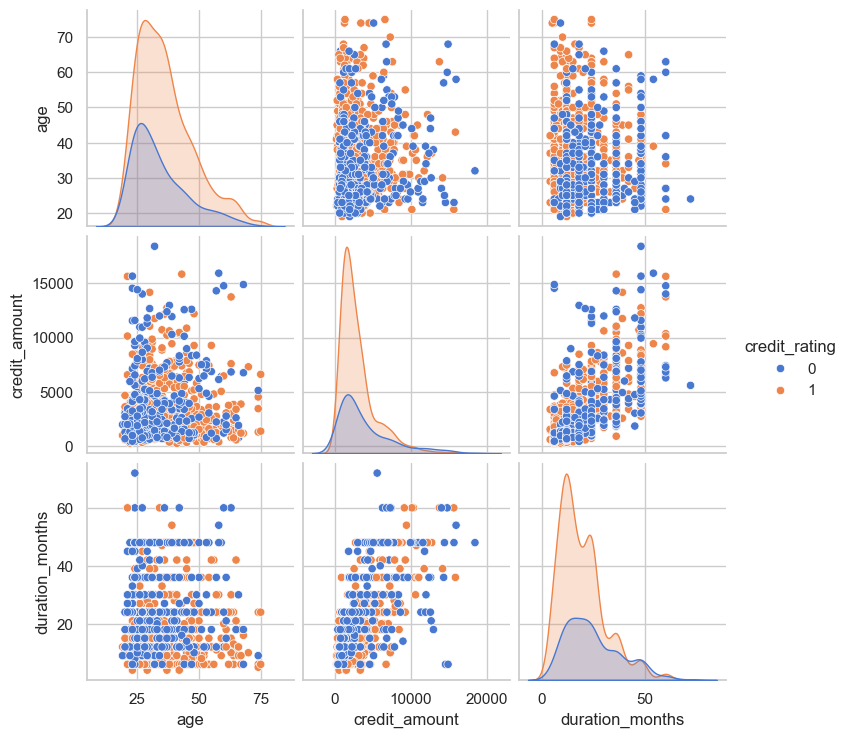

In [33]:
sns.pairplot(df[['age','credit_amount','duration_months','credit_rating']], hue='credit_rating', diag_kind='kde')
plt.show()

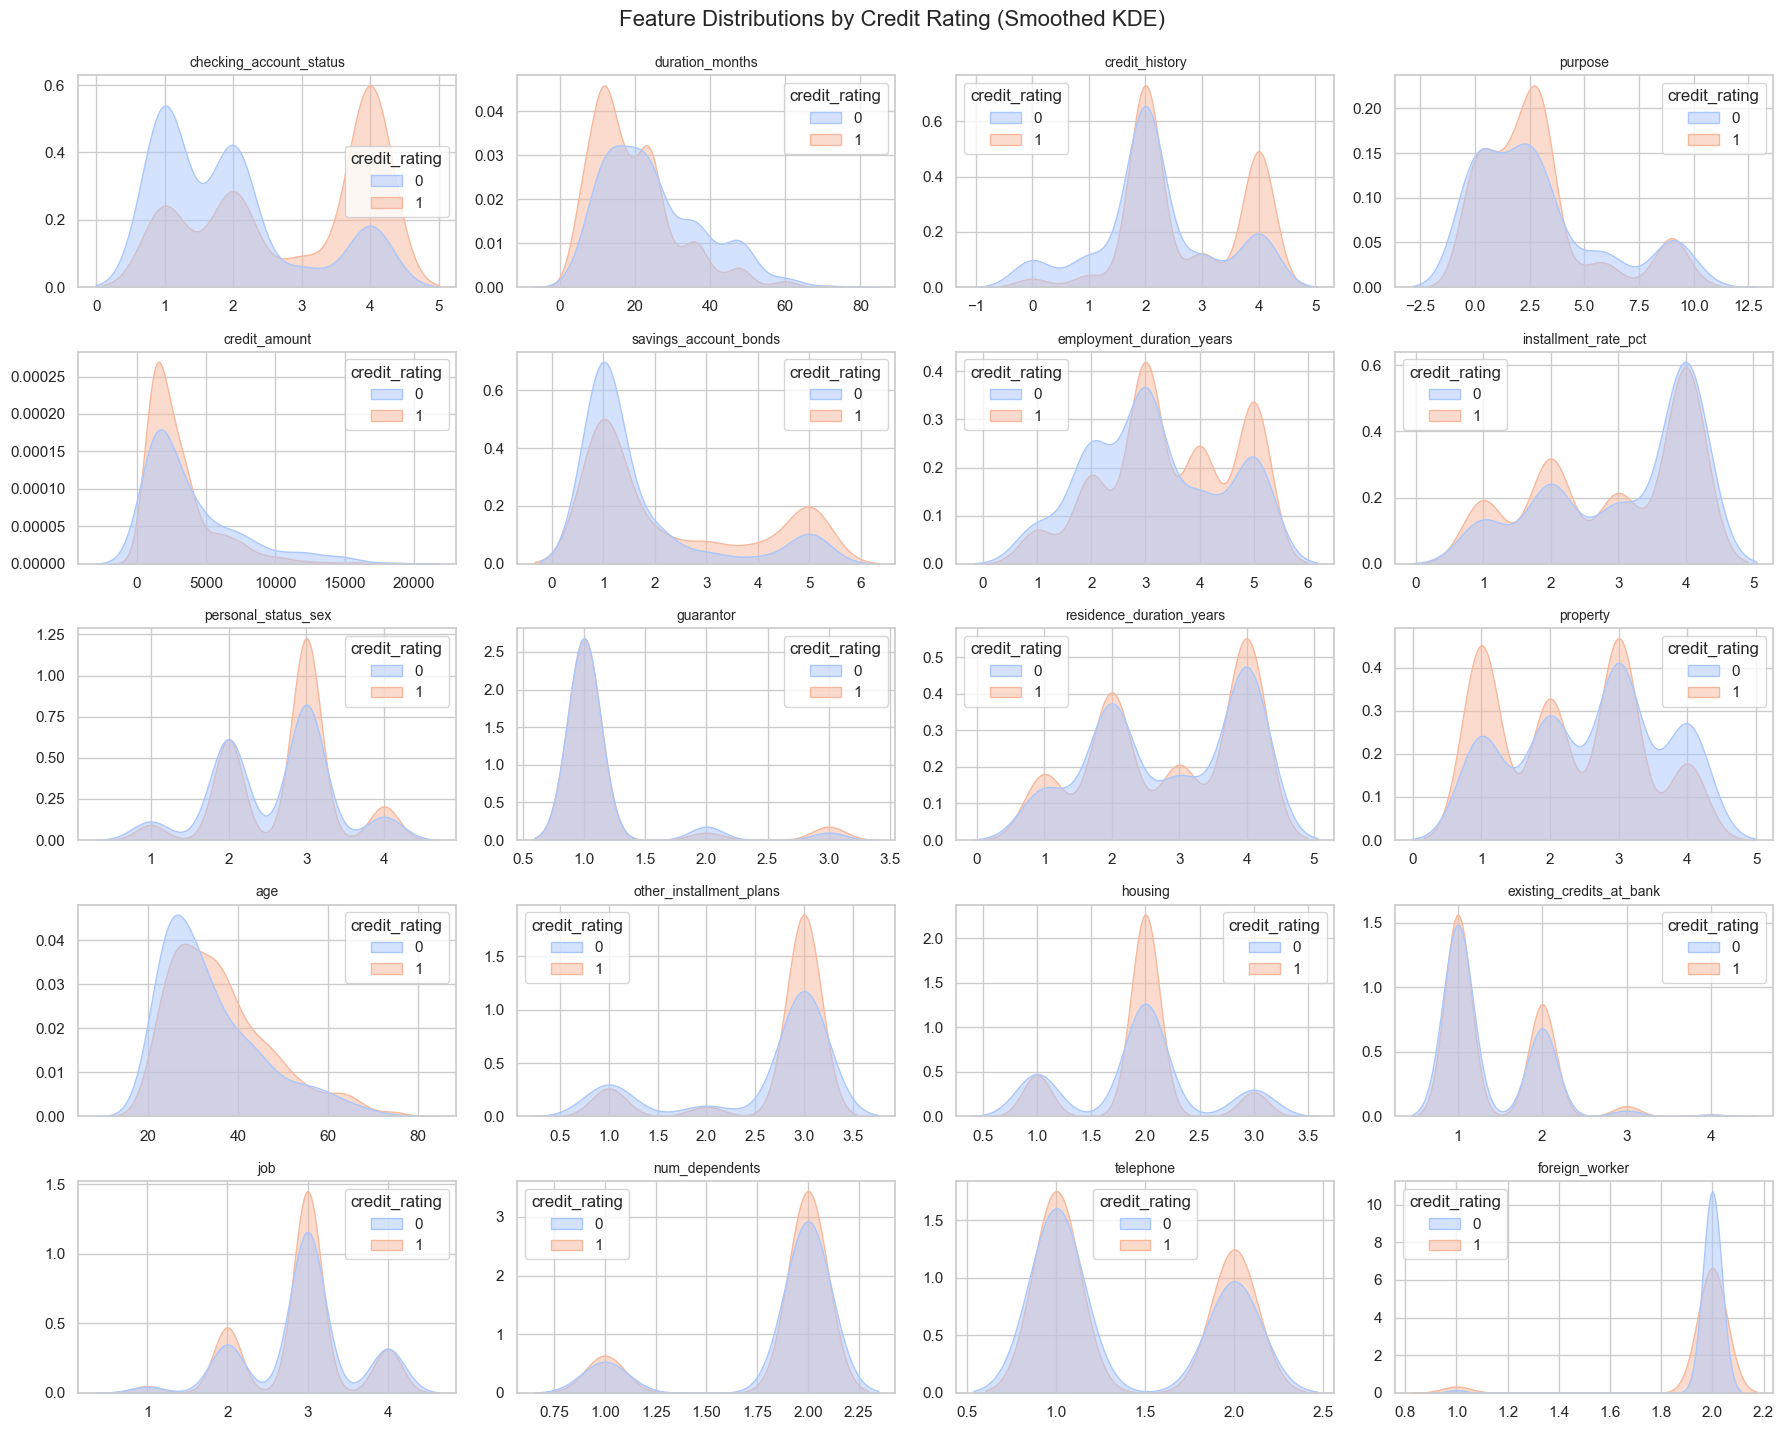

In [ ]:
target = 'credit_rating'
features = [col for col in df.columns if col != target]

# Grid layout (5x4 for 20 features)
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))

plt.figure(figsize=(18, 14))
for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=df, x=col, hue=target, fill=True, common_norm=False, 
                alpha=0.5, palette='coolwarm', linewidth=1)
    plt.title(col, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

plt.suptitle('Feature Distributions by Credit Rating (Smoothed KDE)', fontsize=16, y=1.02)
plt.show()


## Map dataframe to categorical 

In [8]:
data = df.copy()

In [9]:
status = {1:'no checking account', 2:'less than 0 DM', 3:'0 to 200 DM', 4:'200 DM or more'}
data['checking_account_status'] = data['checking_account_status'].map(status)

credit_history = {0 : 'delay in paying off in the past',       
 1 : 'critical account/other credits elsewhere',   
 2 : 'no credits taken/all credits paid back duly',
 3 : 'existing credits paid back duly till now',
 4 : 'all credits at this bank paid back duly'}
data['credit_history'] = data['credit_history'].map(credit_history)

purpose = {0 : 'others', 1 : 'car (new)', 2 : 'car (used)',3 : 'furniture/equipment', 4 : 'radio/television', 
           5 : 'domestic appliances', 6 : 'repairs', 7 : 'education', 8 : 'vacation', 9 : 'retraining', 10 : 'business'}
data['purpose'] = data['purpose'].map(purpose)

savings = {1:'unknown/no savings account', 2 :'less than 100 DM', 3:'100 to 500 DM', 4 :'500 to 1000 DM', 5:'1000 DM or more'}
data['savings_account_bonds'] = data['savings_account_bonds'].map(savings)

employment_duration = {1 : 'unemployed',2 : 'less than 1 year', 3 : '1 to 4 yrs', 4 : '4 to 7 yrs', 5 : '7 yrs or more'}
data['employment_duration_years'] = data['employment_duration_years'].map(employment_duration)

installment_rate = {1 : '35 or more', 2 : '25 to 35', 3 : '20 to 25', 4 : 'less than 20'}
data['installment_rate_pct'] = data['installment_rate_pct'].map(installment_rate)

personal_status_sex = {1 : 'male : divorced/separated', 2 : 'female : non-single or male : single', 3 : 'male : married/widowed', 4 : 'female : single'}
data['personal_status_sex'] = data['personal_status_sex'].map(personal_status_sex)

other_debtors = {1 : 'none', 2 : 'co-applicant', 3 : 'guarantor'}
data['guarantor'] = data['guarantor'].map(other_debtors)

present_residence = {1 : 'less than 1 year', 2 : '1 to 4 yrs', 3 : '4 to 7 yrs', 4 : '7 yrs or more'}
data['residence_duration_years'] = data['residence_duration_years'].map(present_residence)

property = {1 : 'unknown/no property', 2 : 'car or other',3 : 'building soc. savings agr./life insurance', 4 : 'real estate'}
data['property'] = data['property'].map(property)

other_installment_options = {1 : 'bank',2 : 'stores',3 : 'none'}
data['other_installment_plans'] = data['other_installment_plans'].map(other_installment_options)

housing = {1:'for free', 2:'rent', 3:'own'} 
data['housing'] = data['housing'].map(housing)

job={1 : 'unemployed/unskilled - non-resident',2 : 'unskilled-resident',3 : 'skilled employee/official',4 : 'manager/self-employed/highly qualified employee'}
data['job'] = data['job'].map(job)

number_credits = {1 : '1',2 : '2-3', 3 : '4-5',4 : '6 or more'}
data['existing_credits_at_bank'] = data['existing_credits_at_bank'].map(number_credits)

people_liable = {1 : '3 or more', 2 : '0 to 2'}
data['num_dependents'] = data['num_dependents'].map(people_liable)

telephone = {1 : 'no',2 : 'yes (under customer name)'}
data['telephone'] = data['telephone'].map(telephone)

foreign_worker = {1 : 'yes', 2 : 'no'}
data['foreign_worker'] = data['foreign_worker'].map(foreign_worker)

credit_risk = {0 : 1, 1 : 0}
data['credit_rating'] = data['credit_rating'].map(credit_risk)

In [10]:
# Exclude target column
features = [col for col in data.columns if col != 'credit_rating']

# Loop through each feature and display mean (target rate) + count
for feature in features:
    if len(data[feature].unique()) < 12:
        print(f"\n--- {feature.upper()} ---")
        display(
            data.groupby(feature)['credit_rating']
                .agg(['mean','count'])
                .sort_values('mean', ascending=False)
        )



--- CHECKING_ACCOUNT_STATUS ---


,mean,count
checking_account_status,,
no checking account,0.492701,274
less than 0 DM,0.390335,269
0 to 200 DM,0.222222,63
200 DM or more,0.116751,394



--- CREDIT_HISTORY ---


,mean,count
credit_history,,
delay in paying off in the past,0.625000,40
critical account/other credits elsewhere,0.571429,49
no credits taken/all credits paid back duly,0.318868,530
existing credits paid back duly till now,0.318182,88
all credits at this bank paid back duly,0.170648,293



--- PURPOSE ---


,mean,count
purpose,,
repairs,0.440000,50
business,0.416667,12
others,0.380342,234
domestic appliances,0.363636,22
retraining,0.350515,97
radio/television,0.333333,12
car (used),0.320442,181
furniture/equipment,0.221429,280
car (new),0.165049,103



--- SAVINGS_ACCOUNT_BONDS ---


,mean,count
savings_account_bonds,,
unknown/no savings account,0.359867,603
less than 100 DM,0.330097,103
1000 DM or more,0.174863,183
100 to 500 DM,0.174603,63
500 to 1000 DM,0.125000,48



--- EMPLOYMENT_DURATION_YEARS ---


,mean,count
employment_duration_years,,
less than 1 year,0.406977,172
unemployed,0.370968,62
1 to 4 yrs,0.306785,339
7 yrs or more,0.252964,253
4 to 7 yrs,0.224138,174



--- INSTALLMENT_RATE_PCT ---


,mean,count
installment_rate_pct,,
less than 20,0.334034,476
20 to 25,0.286624,157
25 to 35,0.268398,231
35 or more,0.250000,136



--- PERSONAL_STATUS_SEX ---


,mean,count
personal_status_sex,,
male : divorced/separated,0.400000,50
female : non-single or male : single,0.351613,310
female : single,0.271739,92
male : married/widowed,0.266423,548



--- GUARANTOR ---


,mean,count
guarantor,,
co-applicant,0.439024,41
none,0.299890,907
guarantor,0.192308,52



--- RESIDENCE_DURATION_YEARS ---


,mean,count
residence_duration_years,,
1 to 4 yrs,0.314935,308
7 yrs or more,0.300242,413
4 to 7 yrs,0.288591,149
less than 1 year,0.276923,130



--- PROPERTY ---


,mean,count
property,,
real estate,0.435065,154
building soc. savings agr./life insurance,0.307229,332
car or other,0.306034,232
unknown/no property,0.212766,282



--- OTHER_INSTALLMENT_PLANS ---


,mean,count
other_installment_plans,,
bank,0.410072,139
stores,0.404255,47
none,0.275184,814



--- HOUSING ---


,mean,count
housing,,
own,0.411215,107
for free,0.391061,179
rent,0.260504,714



--- EXISTING_CREDITS_AT_BANK ---


,mean,count
existing_credits_at_bank,,
6 or more,0.333333,6
1,0.315956,633
2-3,0.276276,333
4-5,0.214286,28



--- JOB ---


,mean,count
job,,
manager/self-employed/highly qualified employee,0.344595,148
unemployed/unskilled - non-resident,0.318182,22
skilled employee/official,0.295238,630
unskilled-resident,0.280000,200



--- NUM_DEPENDENTS ---


,mean,count
num_dependents,,
0 to 2,0.300592,845
3 or more,0.296774,155



--- TELEPHONE ---


,mean,count
telephone,,
no,0.313758,596
yes (under customer name),0.279703,404



--- FOREIGN_WORKER ---


,mean,count
foreign_worker,,
no,0.307373,963
yes,0.108108,37


## Preprocess

### Process skewed data

In [ ]:
# --- Processed skewed data ---
numerical_columns = ['duration_months','credit_amount','age']
df_continuous = df[numerical_columns]

pt = PowerTransformer(method='box-cox')
power_transformed_array = pt.fit_transform(df_continuous)
ptdf_cont = pd.DataFrame(data = power_transformed_array, columns = df_continuous.columns)
ptdf_cont.head()


,duration_months,credit_amount,age
0,-0.004054,-1.079443,-1.824686
1,-1.160984,0.215350,0.295513
2,-0.689848,-1.382388,-1.412590
3,-0.689848,-0.141779,0.551504
4,-0.689848,-0.112096,0.469891


### Remove insignificant features using statistical tests

In [ ]:
# --- Determining significance based on Chi Square Test ---
def contingency_table(feature):
    p = pd.crosstab(df['credit_rating'],df[feature])
    return(p)

feature = []
pval = []
chi2_result = []
categorical_columns = ['checking_account_status','credit_history','purpose','savings_account_bonds','employment_duration_years',
                       'installment_rate_pct','personal_status_sex','guarantor','residence_duration_years',
                       'property','other_installment_plans','housing','existing_credits_at_bank','job','num_dependents',
                       'telephone','foreign_worker']

for i in categorical_columns[:-1]:
    feature.append(i)
    result = chi2_contingency(contingency_table(i))
    pval.append(round(float(result[1]),6))
    
    if float(result[1]) < 0.05:
        chi2_result.append("Significant")
    else:
        chi2_result.append("Insignificant")
    
chisquare = pd.DataFrame(data={'PValue':pval,'Result':chi2_result},index=feature)
chisquare.sort_values('PValue',ascending=False)

,PValue,Result
num_dependents,1.000000,Insignificant
residence_duration_years,0.861552,Insignificant
job,0.596582,Insignificant
existing_credits_at_bank,0.445144,Insignificant
telephone,0.278876,Insignificant
installment_rate_pct,0.140033,Insignificant
guarantor,0.036056,Significant
personal_status_sex,0.022238,Significant
other_installment_plans,0.001629,Significant
employment_duration_years,0.001045,Significant


### Map categorical features back to numerical

In [14]:
# --- Create a Working Copy ---
df_processed = data.copy()

status = {'no checking account':1, 'less than 0 DM':2, '0 to 200 DM':3, '200 DM or more':4}
df_processed['checking_account_status'] = df_processed['checking_account_status'].map(status)

savings = {'unknown/no savings account':1, 'less than 100 DM':2, '100 to 500 DM':3, '500 to 1000 DM' :4, '1000 DM or more':5}
df_processed['savings_account_bonds'] = df_processed['savings_account_bonds'].map(savings)

employment_duration = {'unemployed':1 ,'less than 1 year':2, '1 to 4 yrs':3, '4 to 7 yrs':4, '7 yrs or more':5}
df_processed['employment_duration_years'] = df_processed['employment_duration_years'].map(employment_duration)

df_processed['purpose'] = df_processed['purpose'].replace({'domestic appliances':'domestic appliances or radio/television',
                                      'radio/television':'domestic appliances or radio/television',
                                      'business':'business or vacation',
                                      'vacation':'business or vacation',
                                      'retraining':'retraining or repairs',
                                      'repairs':'retraining or repairs',
                                      'car (new)':'car (new) or car (used)',
                                      'car (used)':'car (new) or car (used)'})


In [15]:
for col in ptdf_cont.columns:
    df_processed[col] = ptdf_cont[col]

def t_test(mydf,columns):    
    feature = []
    pval = []
    ttest_result = []
    
    for i in columns:
        feature.append(i)
        result = ttest_ind(mydf[mydf["credit_rating"]==1][i], mydf[mydf["credit_rating"]==0][i])
        pval.append(round(float(result[1]),6))
        
        if float(result[1]) < 0.05:
            ttest_result.append("Significant")
        else:
            ttest_result.append("Insignificant")
    
    return(pd.DataFrame(index=feature,data={'PValue':pval,'Result':ttest_result}))
pt_ttest = t_test(df_processed, numerical_columns)
pt_ttest

,PValue,Result
duration_months,0.000000,Significant
credit_amount,0.000775,Significant
age,0.000517,Significant


In [16]:
# --- Determining insignificance features based on Chi Square Test ---
df_processed.drop(columns = chisquare[chisquare['Result'] == 'Insignificant'].index, axis=1,inplace=True)

In [17]:
pt_ohe_df = pd.get_dummies(df_processed, columns = df_processed.drop('credit_rating',axis=1).select_dtypes(include='object').columns, drop_first=True)
print(pt_ohe_df.shape)
pt_ohe_df.head()

(1000, 29)


,checking_account_status,duration_months,credit_amount,savings_account_bonds,employment_duration_years,age,credit_rating,credit_history_critical account/other credits elsewhere,credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/all credits paid back duly,purpose_car (new) or car (used),purpose_domestic appliances or radio/television,purpose_furniture/equipment,purpose_others,purpose_retraining or repairs,personal_status_sex_female : single,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,guarantor_guarantor,guarantor_none,property_car or other,property_real estate,property_unknown/no property,other_installment_plans_none,other_installment_plans_stores,housing_own,housing_rent,foreign_worker_yes
0,1,-0.004054,-1.079443,1,2,-1.824686,0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False
1,1,-1.160984,0.215350,1,3,0.295513,0,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,False,False
2,2,-0.689848,-1.382388,2,4,-1.412590,0,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False
3,1,-0.689848,-0.141779,1,3,0.551504,0,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,True,False,False,False,True
4,1,-0.689848,-0.112096,1,3,0.469891,0,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,False,False,False,True,True


## Modelling

In [23]:
# --- 0. Define the Custom Cost Function and Scorer ---

def calculate_cost(y_true, y_pred):
    """
    Calculates the total cost based on the specified cost matrix.
    Assumes: 0 = Good, 1 = Bad
    Cost of FN (predict 0, actual 1) = 5
    Cost of FP (predict 1, actual 0) = 1
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # If model predicts only one class, confusion matrix might not be 2x2
    if cm.shape != (2, 2):
        return np.inf # Return a high cost to penalize trivial models
    tn, fp, fn, tp = cm.ravel()
    cost = (fn * 5) + (fp * 1)
    return cost

# Create a scorer for use in RFECV and cross-validation.
# We want to MINIMIZE cost, so greater_is_better is False.
custom_scorer = make_scorer(calculate_cost, greater_is_better=False)

In [ ]:

X = pt_ohe_df.drop('credit_rating',axis=1)
y = pt_ohe_df['credit_rating']
sm = SMOTE(random_state = 2) 
X, y = sm.fit_resample(X, y.ravel())
print('After OverSampling, the shape of X_train: {}'.format(X.shape)) 
print('After OverSampling, the shape of y_train: {} \n'.format(y.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y == 0))) 


After OverSampling, the shape of X_train: (1400, 28)
After OverSampling, the shape of y_train: (1400,) 

After OverSampling, counts of label '1': 700
After OverSampling, counts of label '0': 700


C:\Users\ACER\AppData\Local\Temp\ipykernel_11840\1202752032.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X, y = sm.fit_resample(X, y.ravel())


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [54]:
model_smote = []
be_smote = []
ve_smote = []
precision0_smote = []
recall0_smote = []
precision1_smote = []
recall1_smote = []
auc_smote = []


### Logistic

In [ ]:
# --- 2. Cost-Sensitive Feature Selection with RFECV ---

print("\n--- Running Cost-Sensitive Feature Selection with RFECV ---")

# Define the model that RFECV will use internally.
# We make it cost-aware with class_weight.
lr_for_rfe = LogisticRegression(max_iter=1000, random_state=0, class_weight={0: 1, 1: 5})

# Use StratifiedKFold for robust cross-validation on imbalanced data
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RFECV will find the number of features that minimizes our custom cost function.
rfe_cv = RFECV(
    estimator=lr_for_rfe,
    step=1,
    cv=cv_stratified,
    scoring=custom_scorer, # <-- Using our custom cost scorer here!
    n_jobs=-1
)

# Fit RFECV on the full dataset to find the best features
rfe_cv.fit(X, y)

# Get the selected features
features_selected_lr = X.columns[rfe_cv.support_]
print(f"RFECV selected the optimal number of {rfe_cv.n_features_} features.")


# --- 3. Train and Evaluate the Final Model ---

# Split the data, using ONLY the features selected by RFECV
X_train, X_test, y_train, y_test = train_test_split(
    X[features_selected_lr],
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Define the final model, also making it cost-aware
lr_final = LogisticRegression(max_iter=1000, random_state=0, class_weight={0: 1, 1: 5})

# Train the model
lr_final.fit(X_train, y_train)

# Make predictions
y_test_predicted = lr_final.predict(X_test)
y_train_predicted = lr_final.predict(X_train)

# --- 4. Final Performance Evaluation ---

print("\n--- Final Model Performance ---")

# Calculate the all-important total cost on the test set
total_test_cost = calculate_cost(y_test, y_test_predicted)
print(f"Total Cost on Test Set: {total_test_cost}")

# Calculate standard metrics for context
accuracy_test = accuracy_score(y_test, y_test_predicted)
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

print("\n--- Full Classification Report on Test Set ---")
# Specify target_names based on our 0/1 mapping
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))

# Cross-validate the final model's cost performance
# This gives a more robust estimate of how the model will perform on new data
cost_scores = cross_val_score(lr_final, X[features_selected_lr], y, cv=cv_stratified, scoring=custom_scorer)

print("\n--- Cross-Validated Performance ---")
# The scores are negative because we minimized, so we flip the sign
print(f"Mean Cross-Validated Cost: {-np.mean(cost_scores):.2f}")
print(f"Standard Deviation of Cost: {np.std(cost_scores):.2f}")
confusion_matrix(y_test, y_test_predicted)


--- Running Cost-Sensitive Feature Selection with RFECV ---
RFECV selected the optimal number of 25 features.

--- Final Model Performance ---
Total Cost on Test Set: 178
Test Set Accuracy: 68.10%

--- Full Classification Report on Test Set ---
              precision    recall  f1-score   support

    Good (0)       0.89      0.41      0.56       210
     Bad (1)       0.62      0.95      0.75       210

    accuracy                           0.68       420
   macro avg       0.75      0.68      0.66       420
weighted avg       0.75      0.68      0.66       420


--- Cross-Validated Performance ---
Mean Cross-Validated Cost: 109.20
Standard Deviation of Cost: 6.79


array([[ 87, 123],
       [ 11, 199]])

### KNN

In [ ]:
# --- SETUP ---
mm = MinMaxScaler()
kf = KFold(n_splits=5, shuffle=True, random_state=0)
knn = KNeighborsClassifier()

# --- GRID SEARCH CV ---
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'weights': ['uniform', 'distance']
}
GS = GridSearchCV(knn, param_grid, cv=kf, scoring=custom_scorer, n_jobs=-1)
GS.fit(X_train, y_train)

print(f"✅ Best params: {GS.best_params_} with custom scorer = {-GS.best_score_:.4f}")

# --- FINAL MODEL EVALUATION ---
best_knn = KNeighborsClassifier(**GS.best_params_)
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=kf, scoring=custom_scorer)

print(f"Bias Error: {1 - np.mean(cv_scores):.4f}")
print(f"Variance Error: {np.std(cv_scores, ddof=1):.4f}")

best_knn.fit(X_train, y_train)
y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

# --- ACCURACY & REPORT ---
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
final_cost = calculate_cost(y_test, y_test_pred) # Calculate the final cost

print(f"Train Accuracy: {acc_train*100:.2f}%")
print(f"Test Accuracy: {acc_test*100:.2f}%")
print(f"Final Cost on Test Set: {final_cost}") # Added final cost

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


✅ Best params: {'n_neighbors': np.int64(1), 'weights': 'uniform'} with custom scorer = 81.0000
Bias Error: 82.0000
Variance Error: 19.9123
Train Accuracy: 100.00%
Test Accuracy: 82.62%
Final Cost on Test Set: 161

Confusion Matrix:
 [[159  51]
 [ 22 188]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81       210
           1       0.79      0.90      0.84       210

    accuracy                           0.83       420
   macro avg       0.83      0.83      0.83       420
weighted avg       0.83      0.83      0.83       420



### Random Forest


In [ ]:
print("\n--- Running Cost-Sensitive Feature Selection with RFECV ---")

# Define the model that RFECV will use internally.
# We make it cost-aware with class_weight.
rf_for_rfe = RandomForestClassifier(random_state=0, class_weight={0: 1, 1: 5})

# Use StratifiedKFold for robust cross-validation on imbalanced data
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RFECV will find the number of features that minimizes our custom cost function.
rfe_cv = RFECV(
    estimator=rf_for_rfe,
    step=1,
    cv=cv_stratified,
    scoring=custom_scorer, # <-- Using our custom cost scorer here!
    n_jobs=-1
)

# Fit RFECV on the full dataset to find the best features
rfe_cv.fit(X, y)

# Get the selected features
features_selected = X.columns[rfe_cv.support_]
print(f"RFECV selected the optimal number of {rfe_cv.n_features_} features.")


# --- 3. Train and Evaluate the Final Model ---

# Split the data, using ONLY the features selected by RFECV
X_train, X_test, y_train, y_test = train_test_split(
    X[features_selected],
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Define the final model, also making it cost-aware
rf_final = RandomForestClassifier(random_state=0, class_weight={0: 1, 1: 5})

# Train the model
rf_final.fit(X_train, y_train)

# Make predictions
y_test_predicted = rf_final.predict(X_test)
y_train_predicted = rf_final.predict(X_train)

# --- 4. Final Performance Evaluation ---

print("\n--- Final Model Performance ---")

# Calculate the all-important total cost on the test set
total_test_cost = calculate_cost(y_test, y_test_predicted)
print(f"Total Cost on Test Set: {total_test_cost}")

# Calculate standard metrics for context
accuracy_test = accuracy_score(y_test, y_test_predicted)
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

print("\n--- Full Classification Report on Test Set ---")
# Specify target_names based on our 0/1 mapping
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))

# Cross-validate the final model's cost performance
# This gives a more robust estimate of how the model will perform on new data
cost_scores = cross_val_score(rf_final, X[features_selected], y, cv=cv_stratified, scoring=custom_scorer)

print("\n--- Cross-Validated Performance ---")
# The scores are negative because we minimized, so we flip the sign
print(f"Mean Cross-Validated Cost: {-np.mean(cost_scores):.2f}")
print(f"Standard Deviation of Cost: {np.std(cost_scores):.2f}")
confusion_matrix(y_test, y_test_predicted)


--- Running Cost-Sensitive Feature Selection with RFECV ---
RFECV selected the optimal number of 26 features.

--- Final Model Performance ---
Total Cost on Test Set: 215
Test Set Accuracy: 83.10%

--- Full Classification Report on Test Set ---
              precision    recall  f1-score   support

    Good (0)       0.83      0.83      0.83       210
     Bad (1)       0.83      0.83      0.83       210

    accuracy                           0.83       420
   macro avg       0.83      0.83      0.83       420
weighted avg       0.83      0.83      0.83       420


--- Cross-Validated Performance ---
Mean Cross-Validated Cost: 127.00
Standard Deviation of Cost: 11.98


array([[175,  35],
       [ 36, 174]])

**Random Forest Performance Commentary**

The Random Forest model is a strong, balanced performer but is ultimately not the optimal choice for this specific cost-sensitive problem.

**Observations:**
*   **High F1-Score (0.83):** It achieves a statistically excellent F1-score for the critical 'bad' class, demonstrating a good balance between precision and recall.
*   **Symmetrical Performance:** The classification report is remarkably symmetrical, with precision and recall at 0.83 for both 'good' and 'bad' classes.
*   **Suboptimal Cost (215):** Despite its strong statistical performance, its financial cost is significantly higher than more specialized models.

**Interpretation:**
Random Forest's inherent strength is creating a robust, highly accurate model. Even with cost-sensitive weighting, its nature is to avoid overfitting and remain balanced. It resists skewing its predictions to the extreme degree required by the asymmetric cost matrix.

**Conclusion:**
While a powerful general-purpose model, the Random Forest is "too balanced" for this task. It prioritizes overall accuracy, resulting in a higher financial cost compared to simpler models that can be more aggressively focused on eliminating costly False Negatives.

### Bagged Logistic Regression

In [ ]:
# =================================================================================
# --- Pipeline for Bagged Logistic Regression ---
# =================================================================================

print("\n" + "="*70)
print(" " * 15 + "Processing Model: Bagged Logistic Regression")
print("="*70)


# --- Step 1: Tune n_estimators to Minimize Cost ---
print("\n--- Step 1: Finding optimal n_estimators for Bagging ---")

# Define the base model that will be bagged. It MUST be cost-aware.
lr_base = LogisticRegression(max_iter=1000, random_state=0, class_weight={0: 1, 1: 5})

# Loop to find the best number of estimators based on our custom cost
n_estimators_range = np.arange(1, 101, 5) # Test from 1 to 100 in steps of 5 for speed
cv_costs = []

for n in n_estimators_range:
    # Create the Bagging Classifier with the new 'estimator' syntax
    bagged_model = BaggingClassifier(estimator=lr_base, n_estimators=n, random_state=0, n_jobs=-1)
    
    # Get cross-validated scores using the custom cost scorer
    scores = cross_val_score(bagged_model, X[features_selected_lr], y, cv=cv_stratified, scoring=custom_scorer)
    
    # Append the mean cost (scores are negative, so we flip the sign)
    cv_costs.append(-np.mean(scores))
    print(f"  n_estimators = {n}, Mean Cost = {-np.mean(scores):.2f}")

# Find the best number of estimators that resulted in the lowest cost
optimal_n_estimators = n_estimators_range[np.argmin(cv_costs)]
min_cost = np.min(cv_costs)

print(f"\n✅ Optimal n_estimators found: {optimal_n_estimators} (with a mean cross-validated cost of {min_cost:.2f})")


# --- Step 2: Train and Evaluate the Final Bagged Model ---

# Split the data, using ONLY the pre-selected features
X_train, X_test, y_train, y_test = train_test_split(
    X[features_selected_lr],
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Create the final, optimized Bagging Classifier
lr_bag_final = BaggingClassifier(
    estimator=lr_base,
    n_estimators=optimal_n_estimators,
    random_state=0,
    n_jobs=-1
)

# Train the model
print(f"\n--- Training final Bagged LR with {optimal_n_estimators} estimators... ---")
lr_bag_final.fit(X_train, y_train)

# Make predictions
y_test_predicted = lr_bag_final.predict(X_test)


# --- Step 3: Final Performance Evaluation ---
print("\n" + "-"*70)
print(" " * 18 + "Final Bagged Model Performance")
print("-"*70)

# Calculate the all-important total cost on the test set
total_test_cost = calculate_cost(y_test, y_test_predicted)
print(f"\nTotal Cost on Test Set: {total_test_cost}")

# Calculate standard metrics for context
accuracy_test = accuracy_score(y_test, y_test_predicted)
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

# Print the confusion matrix to see the error distribution
cm = confusion_matrix(y_test, y_test_predicted, labels=[0, 1])
print("\n--- Confusion Matrix on Test Set ---")
print("                     Predicted Good (0)  Predicted Bad (1)")
print(f"Actual Good (0)          {cm[0][0]:<19} {cm[0][1]}")
print(f"Actual Bad (1)           {cm[1][0]:<19} {cm[1][1]}")
print("\nBreakdown of Errors & Cost:")
print(f"  - False Positives (FP): {cm[0][1]} (Cost = {cm[0][1]})")
print(f"  - False Negatives (FN): {cm[1][0]} (Cost = {cm[1][0] * 5})")

print("\n--- Full Classification Report on Test Set ---")
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))

# --- Step 4: Final Stability Check ---
cost_scores = cross_val_score(lr_bag_final, X[features_selected_lr], y, cv=cv_stratified, scoring=custom_scorer)
print("\n--- Model Stability ---")
print(f"  > Mean Cross-Validated Cost: {-np.mean(cost_scores):.2f}")
print(f"  > Standard Deviation of Cost: {np.std(cost_scores):.2f}")
print("="*70)


               Processing Model: Bagged Logistic Regression

--- Step 1: Finding optimal n_estimators for Bagging ---
  n_estimators = 1, Mean Cost = 111.20
  n_estimators = 6, Mean Cost = 108.40
  n_estimators = 11, Mean Cost = 111.00
  n_estimators = 16, Mean Cost = 110.00
  n_estimators = 21, Mean Cost = 110.00
  n_estimators = 26, Mean Cost = 110.60
  n_estimators = 31, Mean Cost = 109.20
  n_estimators = 36, Mean Cost = 110.20
  n_estimators = 41, Mean Cost = 111.40
  n_estimators = 46, Mean Cost = 111.40
  n_estimators = 51, Mean Cost = 110.60
  n_estimators = 56, Mean Cost = 110.60
  n_estimators = 61, Mean Cost = 111.00
  n_estimators = 66, Mean Cost = 111.20
  n_estimators = 71, Mean Cost = 111.00
  n_estimators = 76, Mean Cost = 111.00
  n_estimators = 81, Mean Cost = 111.00
  n_estimators = 86, Mean Cost = 111.40
  n_estimators = 91, Mean Cost = 111.40
  n_estimators = 96, Mean Cost = 110.40

✅ Optimal n_estimators found: 6 (with a mean cross-validated cost of 108.40)

--- 

### Bagged KNN

In [63]:
# =================================================================================
# --- Pipeline for Bagged KNN ---
# =================================================================================

print("\n" + "="*70)
print(" " * 15 + "Processing Model: Bagged K-Nearest Neighbors")
print("="*70)

# --- Step 1: Find the Optimal Base KNN Model ---
print("\n--- Step 1: Tuning base KNN hyperparameters with GridSearchCV ---")
knn_base_model = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': np.arange(5, 32, 2), # A reasonable range for KNN
    'weights': ['uniform', 'distance']
}
gs_knn = GridSearchCV(knn_base_model, param_grid_knn, cv=kf, scoring=custom_scorer, n_jobs=-1)
gs_knn.fit(X_train, y_train)

# This is our best "building block"
best_knn_params = gs_knn.best_params_
print(f"✅ Best base KNN params found: {best_knn_params} (with cost {-gs_knn.best_score_:.2f})")
optimal_base_knn = KNeighborsClassifier(**best_knn_params)


# --- Step 2: Tune n_estimators for the Bagging Classifier ---
print("\n--- Step 2: Finding optimal n_estimators for Bagging ---")
n_estimators_range = np.arange(1, 51, 5) # Test from 1 to 50 in steps of 5
cv_costs = []

for n in n_estimators_range:
    bagged_model = BaggingClassifier(estimator=optimal_base_knn, n_estimators=n, random_state=0, n_jobs=-1)
    scores = cross_val_score(bagged_model, X_train, y_train, cv=kf, scoring=custom_scorer)
    cv_costs.append(-np.mean(scores))
    print(f"  n_estimators = {n}, Mean Cost = {-np.mean(scores):.2f}")

optimal_n_estimators = n_estimators_range[np.argmin(cv_costs)]
min_cost = np.min(cv_costs)
print(f"\n✅ Optimal n_estimators found: {optimal_n_estimators} (with a mean cost of {min_cost:.2f})")


# --- Step 3: Train and Evaluate the Final Bagged Model ---
print("\n--- Step 3: Training and Evaluating the final Bagged KNN model ---")
knn_bagged_final = BaggingClassifier(
    estimator=optimal_base_knn,
    n_estimators=optimal_n_estimators,
    random_state=0,
    n_jobs=-1
)
knn_bagged_final.fit(X_train, y_train)
y_test_predicted = knn_bagged_final.predict(X_test)


# --- Step 4: Final Performance Evaluation ---
total_test_cost = calculate_cost(y_test, y_test_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)

print(f"\nTotal Cost on Test Set: {total_test_cost}")
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

cm = confusion_matrix(y_test, y_test_predicted, labels=[0, 1])
print("\n--- Confusion Matrix on Test Set ---")
print("                     Predicted Good (0)  Predicted Bad (1)")
print(f"Actual Good (0)          {cm[0][0]:<19} {cm[0][1]}")
print(f"Actual Bad (1)           {cm[1][0]:<19} {cm[1][1]}")

print("\n--- Full Classification Report on Test Set ---")
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))
print("="*70)



               Processing Model: Bagged K-Nearest Neighbors

--- Step 1: Tuning base KNN hyperparameters with GridSearchCV ---
✅ Best base KNN params found: {'n_neighbors': np.int64(5), 'weights': 'distance'} (with cost 97.60)

--- Step 2: Finding optimal n_estimators for Bagging ---
  n_estimators = 1, Mean Cost = 127.00
  n_estimators = 6, Mean Cost = 94.60
  n_estimators = 11, Mean Cost = 96.80
  n_estimators = 16, Mean Cost = 98.00
  n_estimators = 21, Mean Cost = 97.40
  n_estimators = 26, Mean Cost = 95.20
  n_estimators = 31, Mean Cost = 98.60
  n_estimators = 36, Mean Cost = 97.20
  n_estimators = 41, Mean Cost = 97.60
  n_estimators = 46, Mean Cost = 95.40

✅ Optimal n_estimators found: 6 (with a mean cost of 94.60)

--- Step 3: Training and Evaluating the final Bagged KNN model ---

Total Cost on Test Set: 188
Test Set Accuracy: 80.95%

--- Confusion Matrix on Test Set ---
                     Predicted Good (0)  Predicted Bad (1)
Actual Good (0)          157                

### Boosted Random Forest 

In [64]:
# =================================================================================
# --- Pipeline for Boosted Random Forest ---
# =================================================================================

print("\n" + "="*70)
print(" " * 15 + "Processing Model: Boosted Random Forest (AdaBoost)")
print("="*70)

# --- Step 1: Tune the Base 'Weak' Random Forest ---
print("\n--- Step 1: Tuning the base 'weak' RandomForest estimator ---")
# A weak learner should be constrained. We'll test small depths and estimators.
rf_weak_learner = RandomForestClassifier(random_state=0, class_weight={0: 1, 1: 5})
param_grid_rf = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 3, 5]
}
gs_rf = GridSearchCV(rf_weak_learner, param_grid_rf, cv=cv_stratified, scoring=custom_scorer, n_jobs=-1)
# Tune on the data with the pre-selected features
gs_rf.fit(X[features_selected], y)

best_rf_params = gs_rf.best_params_
print(f"✅ Best base RF params found: {best_rf_params} (with cost {-gs_rf.best_score_:.2f})")
optimal_base_rf = RandomForestClassifier(random_state=0, class_weight={0: 1, 1: 5}, **best_rf_params)


# --- Step 2: Tune the AdaBoost Wrapper ---
print("\n--- Step 2: Tuning the AdaBoost wrapper (n_estimators and learning_rate) ---")
adaboost_model = AdaBoostClassifier(estimator=optimal_base_rf, random_state=0)
param_grid_adaboost = {
    'n_estimators': [10, 20, 30, 50],
    'learning_rate': [0.1, 0.5, 1.0]
}
gs_adaboost = GridSearchCV(adaboost_model, param_grid_adaboost, cv=cv_stratified, scoring=custom_scorer, n_jobs=-1)
gs_adaboost.fit(X[features_selected], y)

best_adaboost_params = gs_adaboost.best_params_
print(f"✅ Best AdaBoost params found: {best_adaboost_params} (with cost {-gs_adaboost.best_score_:.2f})")


# --- Step 3: Train and Evaluate the Final Boosted Model ---
print("\n--- Step 3: Training and Evaluating the final Boosted RF model ---")

# Split the data, using ONLY the features selected previously
X_train, X_test, y_train, y_test = train_test_split(
    X[features_selected],
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Create the final, fully optimized model
boosted_rf_final = AdaBoostClassifier(
    estimator=optimal_base_rf,
    **best_adaboost_params,
    random_state=0
)

boosted_rf_final.fit(X_train, y_train)
y_test_predicted = boosted_rf_final.predict(X_test)


# --- Step 4: Final Performance Evaluation ---
total_test_cost = calculate_cost(y_test, y_test_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)

print("\n" + "-"*70)
print(" " * 18 + "Final Boosted RF Performance")
print("-"*70)

print(f"\nTotal Cost on Test Set: {total_test_cost}")
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

cm = confusion_matrix(y_test, y_test_predicted, labels=[0, 1])
print("\n--- Confusion Matrix on Test Set ---")
print("                     Predicted Good (0)  Predicted Bad (1)")
print(f"Actual Good (0)          {cm[0][0]:<19} {cm[0][1]}")
print(f"Actual Bad (1)           {cm[1][0]:<19} {cm[1][1]}")

print("\n--- Full Classification Report on Test Set ---")
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))
print("="*70)


               Processing Model: Boosted Random Forest (AdaBoost)

--- Step 1: Tuning the base 'weak' RandomForest estimator ---
✅ Best base RF params found: {'max_depth': 5, 'n_estimators': 20} (with cost 110.80)

--- Step 2: Tuning the AdaBoost wrapper (n_estimators and learning_rate) ---
✅ Best AdaBoost params found: {'learning_rate': 0.5, 'n_estimators': 20} (with cost 98.40)

--- Step 3: Training and Evaluating the final Boosted RF model ---

----------------------------------------------------------------------
                  Final Boosted RF Performance
----------------------------------------------------------------------

Total Cost on Test Set: 165
Test Set Accuracy: 77.86%

--- Confusion Matrix on Test Set ---
                     Predicted Good (0)  Predicted Bad (1)
Actual Good (0)          135                 75
Actual Bad (1)           18                  192

--- Full Classification Report on Test Set ---
              precision    recall  f1-score   support

    Go

### Gradient Boosting

In [ ]:
# =================================================================================
# --- Pipeline for Gradient Boosting ---
# =================================================================================

print("\n" + "="*70)
print(" " * 15 + "Processing Model: Gradient Boosting")
print("="*70)

# --- Step 1: Cost-Sensitive Feature Selection with RFECV ---
print("\n--- Step 1: Running Cost-Sensitive Feature Selection with RFECV ---")

# Define the base model that RFECV will use to rank features.
gb_for_rfe = GradientBoostingClassifier(random_state=0, n_estimators=50) # A smaller n_estimators is fine for ranking

# RFECV will find the number of features that minimizes our custom cost function.
rfe_cv = RFECV(
    estimator=gb_for_rfe,
    step=1,
    cv=cv_stratified,
    scoring=custom_scorer,
    n_jobs=-1
)

# Fit RFECV on the full dataset to find the best feature set
rfe_cv.fit(X.values, y) # Using .values for numpy array input

# Get the selected features
features_selected = X.columns[rfe_cv.support_]
print(f" > RFECV selected the optimal number of {rfe_cv.n_features_} features.")


# --- Step 2: Tune Hyperparameters with GridSearchCV ---
print("\n--- Step 2: Tuning Hyperparameters with GridSearchCV ---")

# Split the data, using ONLY the features selected by RFECV
X_train, X_test, y_train, y_test = train_test_split(
    X[features_selected],
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Define the Gradient Boosting model and a grid of parameters to search
gb_tuner = GradientBoostingClassifier(random_state=0)
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0] # Adds robustness
}

gs_gb = GridSearchCV(
    estimator=gb_tuner,
    param_grid=param_grid_gb,
    cv=cv_stratified,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the training data with the selected features
gs_gb.fit(X_train, y_train)
best_gb_model = gs_gb.best_estimator_

print(f"\n > Best parameters found: {gs_gb.best_params_}")
print(f" > Best cross-validation cost: {-gs_gb.best_score_:.2f}")


# --- Step 3: Train and Evaluate the Final Model ---
print("\n--- Step 3: Evaluating the final tuned Gradient Boosting model ---")

# The best_gb_model is already trained, so we can use it directly for predictions
y_test_predicted = best_gb_model.predict(X_test)

# --- 4. Final Performance Evaluation ---
total_test_cost = calculate_cost(y_test, y_test_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)

print("\n" + "-"*70)
print(" " * 18 + "Final Gradient Boosting Performance")
print("-"*70)

print(f"\nTotal Cost on Test Set: {total_test_cost}")
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

cm = confusion_matrix(y_test, y_test_predicted, labels=[0, 1])
print("\n--- Confusion Matrix on Test Set ---")
print("                     Predicted Good (0)  Predicted Bad (1)")
print(f"Actual Good (0)          {cm[0][0]:<19} {cm[0][1]}")
print(f"Actual Bad (1)           {cm[1][0]:<19} {cm[1][1]}")

print("\n--- Full Classification Report on Test Set ---")
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))

# --- Step 5: Final Stability Check ---
cost_scores = cross_val_score(best_gb_model, X[features_selected], y, cv=cv_stratified, scoring=custom_scorer, n_jobs=-1)
print("\n--- Model Stability ---")
print(f"  > Mean Cross-Validated Cost: {-np.mean(cost_scores):.2f}")
print(f"  > Standard Deviation of Cost: {np.std(cost_scores):.2f}")
print("="*70)


               Processing Model: Gradient Boosting

--- Step 1: Running Cost-Sensitive Feature Selection with RFECV ---
 > RFECV selected the optimal number of 20 features.

--- Step 2: Tuning Hyperparameters with GridSearchCV ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 > Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
 > Best cross-validation cost: 100.20

--- Step 3: Evaluating the final tuned Gradient Boosting model ---

----------------------------------------------------------------------
                  Final Gradient Boosting Performance
----------------------------------------------------------------------

Total Cost on Test Set: 219
Test Set Accuracy: 82.14%

--- Confusion Matrix on Test Set ---
                     Predicted Good (0)  Predicted Bad (1)
Actual Good (0)          171                 39
Actual Bad (1)           36                  174

--- Full Classification Report on Test Set ---


### XGBoost

In [ ]:
# =================================================================================
# --- Pipeline for Cost-Sensitive XGBoost ---
# =================================================================================

print("\n" + "="*70)
print(" " * 15 + "Processing Model: Cost-Sensitive XGBoost")
print("="*70)

# Calculate the ratio for scale_pos_weight. This is the key parameter.
# It's the number of negative samples / number of positive samples.
scale_pos_weight_value = np.sum(y == 0) / np.sum(y == 1)
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")


# --- Step 1: Cost-Sensitive Feature Selection with RFECV ---
print("\n--- Step 1: Running Cost-Sensitive Feature Selection with RFECV ---")

# Define the XGBoost model that RFECV will use. It MUST be cost-aware.
xgb_for_rfe = XGBClassifier(random_state=0, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value)

rfe_cv = RFECV(
    estimator=xgb_for_rfe,
    step=1,
    cv=cv_stratified,
    scoring=custom_scorer,
    n_jobs=-1
)

rfe_cv.fit(X, y) # Fit on the full, imbalanced data
features_selected = X.columns[rfe_cv.support_]
print(f" > RFECV selected the optimal number of {rfe_cv.n_features_} features.")

# --- Step 2: Tune Hyperparameters with GridSearchCV ---
print("\n--- Step 2: Tuning Hyperparameters with GridSearchCV ---")

X_train, X_test, y_train, y_test = train_test_split(X[features_selected], y, test_size=0.3, random_state=42, stratify=y)

# The tuner model must also be cost-aware
xgb_tuner = XGBClassifier(random_state=0, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

gs_xgb = GridSearchCV(
    estimator=xgb_tuner,
    param_grid=param_grid_xgb,
    cv=cv_stratified,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=1
)

# NOTE: GridSearchCV should be fit on the TRAINING data only.
gs_xgb.fit(X_train, y_train)
best_xgb_model = gs_xgb.best_estimator_
print(f"\n > Best parameters found: {gs_xgb.best_params_}")
print(f" > Best cross-validation cost: {-gs_xgb.best_score_:.2f}")

# --- Step 3: Final Performance Evaluation ---
print("\n--- Step 3: Evaluating the final tuned XGBoost model ---")

y_test_predicted = best_xgb_model.predict(X_test)

total_test_cost = calculate_cost(y_test, y_test_predicted)
accuracy_test = accuracy_score(y_test, y_test_predicted)

print("\n" + "-"*70)
print(" " * 18 + "Final XGBoost Performance")
print("-"*70)

print(f"\nTotal Cost on Test Set: {total_test_cost}")
print(f"Test Set Accuracy: {accuracy_test*100:.2f}%")

cm = confusion_matrix(y_test, y_test_predicted, labels=[0, 1])
print("\n--- Confusion Matrix on Test Set ---")
print("                     Predicted Good (0)  Predicted Bad (1)")
print(f"Actual Good (0)          {cm[0][0]:<19} {cm[0][1]}")
print(f"Actual Bad (1)           {cm[1][0]:<19} {cm[1][1]}")

print("\n--- Full Classification Report on Test Set ---")
print(classification_report(y_test, y_test_predicted, target_names=['Good (0)', 'Bad (1)']))
print("="*70)


               Processing Model: Cost-Sensitive XGBoost
Calculated scale_pos_weight for XGBoost: 1.00

--- Step 1: Running Cost-Sensitive Feature Selection with RFECV ---
 > RFECV selected the optimal number of 27 features.

--- Step 2: Tuning Hyperparameters with GridSearchCV ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

 > Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
 > Best cross-validation cost: 105.00

--- Step 3: Evaluating the final tuned XGBoost model ---

----------------------------------------------------------------------
                  Final XGBoost Performance
----------------------------------------------------------------------

Total Cost on Test Set: 224
Test Set Accuracy: 80.95%

--- Confusion Matrix on Test Set ---
                     Predicted Good (0)  Predicted Bad (1)
Actual Good (0)          166                 44
Actual Bad (1)           36                  174

--- Full Classifi